In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
from scipy.special import expit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mode
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
import wandb
from sklearn.model_selection import KFold


In [5]:
class MyDecisionTreeClassifier:
    def __init__(self, **kwargs):
        """
        Initialize the Decision Tree Classifier.

        Parameters:
        - **kwargs: Any additional arguments accepted by DecisionTreeClassifier
        """
        self.model = DecisionTreeClassifier(**kwargs)

    def fit(self, X_train, y_train):
        """
        Fit the Decision Tree Classifier to the training data.

        Parameters:
        - X_train: Training features
        - y_train: Training labels
        """
        self.model.fit(X_train, y_train)

    def validate(self,X_val, y_val):
        predictions = self.model.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        return accuracy

    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions
    
    def getClassificationReport(self, y_true, y_pred):
        self.report = classification_report(y_pred,y_true,zero_division=1)
        return self.report
    



In [6]:
class MyDecisionTreeRegressor:
    def __init__(self, **kwargs):
        self.model = DecisionTreeRegressor(**kwargs)
        self.confidence_metric = None

    def fit(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def compute_metrics(self,X_val,y_val):
        predictions_val = self.model.predict(X_val)
        mse_val = mean_squared_error(y_val, predictions_val)
        # Confidence metric is the inverse of MSE on validation data (higher confidence for lower MSE)
        self.confidence_metric = 1 / (1 + mse_val)
        confidence_metric = self.confidence_metric
        return mse_val,confidence_metric

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions
    
    def plot_predictions_vs_actual(self,predictions, actual, title="Predictions vs Actual"):
        plt.figure(figsize=(10, 6))
        plt.plot(predictions, label='Predictions', marker='o')
        plt.plot(actual, label='Actual', marker='x')
        plt.title(title)
        plt.xlabel('Sample Index')
        plt.ylabel('Values')
        plt.legend()
        plt.show()



In [7]:
class RandomForest:
    def __init__(self, num_trees,max_depth,min_samples_split,num_features,task):
        self.trees = []
        self.feat_indices = []
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.min_samples = min_samples_split
        self.num_fetures = num_features 
        self.task = task
        
    # selecting f fraction of dataset and m features randomly
    def _bootstrap_samples(self,f,m,X_train,y_train):
        
        if m>X_train.shape[1]:
            print('value of m exceeds number of features!')
            return None,None
        
        num_samples = int(f*X_train.shape[0])
        ind = np.random.choice(X_train.shape[0],size=num_samples, replace=True)
        X_sampled = X_train[ind]
        y_sampled = y_train[ind]
        
        num_features = X_sampled.shape[1]
        feat_ind = np.random.choice(num_features, size=m, replace=False)
        X_random_features = X_sampled[:, feat_ind]
        
        return X_random_features, y_sampled, feat_ind
            
        
    def fit(self,f,m,X_train, y_train):
        for i in range(self.num_trees):
            if self.task=='classification':
                model = MyDecisionTreeClassifier(max_depth=self.max_depth, min_samples_split=self.min_samples)
                X_new, y_new, feat_ind = self._bootstrap_samples(f,m,X_train, y_train)
                model.fit(X_new, y_new)
                self.trees.append(model)
                self.feat_indices.append(feat_ind)
            else:
                model = MyDecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples)
                X_new, y_new, feat_ind = self._bootstrap_samples(f,m,X_train,y_train)
                model.fit(X_new,y_new)
                self.trees.append(model)
                self.feat_indices.append(feat_ind)
                
    
    def predict(self, X_test):
        predictions = []
        for i in range(self.num_trees):
            X_test_sampled = X_test[:,self.feat_indices[i]]
            y_pred = self.trees[i].predict(X_test_sampled)
            predictions.append(y_pred)
        
        predictions = np.array(predictions)
        predictions = np.swapaxes(predictions, 0,1)
        
        predictions = np.sum(predictions,axis=1)/self.num_trees
        predictions = np.where(predictions<0.5,0,1)
        
        return predictions        
    
    def regress(self, X_test):
        predictions = []
        for i in range(self.num_trees):
            X_test_sampled = X_test[:,self.feat_indices[i]]
            y_pred = self.trees[i].predict(X_test_sampled)
            predictions.append(y_pred)
        
        predictions = np.array(predictions)
        predictions = np.swapaxes(predictions, 0,1)
        predictions = np.mean(predictions,axis=1)
        # print(predictions)
        
        return predictions
    
        
            
            
        

In [44]:
# loading the data
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

num_features = df.shape[1]-1
num_classes = df.iloc[:, -1].nunique()

X = df.iloc[:, :-1].values
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std


f=0.8

y = df.iloc[:, -1].values
y = y - 3

y = y/5
y = np.where(y<0.5,0,1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [45]:
rf_classifier = RandomForest(num_trees=11,max_depth=10,min_samples_split=2,num_features=5,task='classification')

In [46]:
rf_classifier.fit(f=0.9,m=8,X_train=X_train, y_train=y_train)

In [47]:

predictions = rf_classifier.predict(X_test)
print('Actual : ',y_test)
print('Predicted : ',predictions)
report = classification_report(predictions,y_test,zero_division=1)
print(report)

Actual :  [1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0
 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1
 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1
 1 1 0 1]
Predicted :  [1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1
 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1
 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1
 1 1 1 1]
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        53
           1       0.82      0.82      0.82        62

    accuracy                           0.81       115
   macro avg       0.81      0.81      0.81       115
weighted avg       0.81      0.81      0.81       115



In [29]:
dataset_path = './HousingData.csv'
df = pd.read_csv(dataset_path)

Y = df.iloc[:, -1].values.reshape(-1, 1)
X = df.iloc[:, :-1].values

# finding nan values in the data and replacing by 0
X = np.nan_to_num(X, nan=0)
mean_values = np.mean(X, axis=0)
std_dev_values = np.std(X, axis=0)

# Perform Z-score normalization
X = (X - mean_values) / std_dev_values

print('number of samples  : ',X.shape[0])
print('number of features : ',X.shape[1])

f=0.8 # train fraction
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


number of samples  :  506
number of features :  13


### Running the Random Forest on best hyper-parameters (Regression)

In [30]:
rf_regressor = RandomForest(num_trees=10,max_depth=10,min_samples_split=2,num_features=5,task='regression')

In [31]:
rf_regressor.fit(f=0.9,m=7,X_train=X_train, y_train=y_train)


In [32]:
predictions = rf_regressor.regress(X_test)
print('Ground Truth : ',y_test.reshape(1,-1))
print('Predictions : ',np.round(predictions,2))

mse = mean_squared_error(y_test, predictions)
print('---------------------------\nMSE : ',mse)

Ground Truth :  [[23.1 24.8 31.5 24.2 50.  19.7 23.2 15.1 21.5 23.6 50.  23.8 17.9 29.
  20.1 16.1  7.  20.8  7.  20.3 22.5 26.5 12.7 30.8 22.6  9.6 29.8 20.6
  23.4 16.8 19.4 18.9 21.4 21.2 21.7 24.1 20.  10.9 20.  19.4 18.8 10.4
  19.1 14.  17.4 10.8 14.9 14.1  9.7 13.8 48.5]]
Predictions :  [18.89 24.54 30.19 23.14 44.05 18.88 22.86 11.8  23.15 24.46 43.84 23.34
 12.25 27.38 19.37 18.3  15.12 18.49 10.45 22.61 22.53 25.4  15.19 30.3
 23.74 14.34 28.09 19.4  24.34 20.7  20.37 18.17 22.78 21.58 19.84 24.41
 21.35 11.79 17.72 15.96 19.   10.96 18.13 15.55 19.94 13.1  14.13 15.39
 11.98 14.22 45.28]
---------------------------
MSE :  6.85794581950259


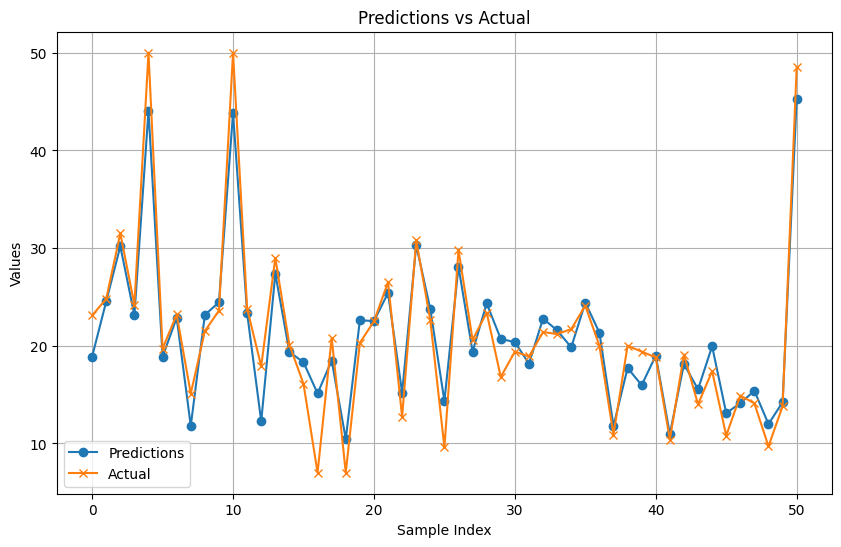

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predictions', marker='o')
plt.plot(y_test, label='Actual', marker='x')
plt.title("Predictions vs Actual")
plt.xlabel('Sample Index')
plt.ylabel('Values')
plt.legend()
plt.grid()
plt.show()

### Hyperparameter Tuning for Random Forest Regressor

In [16]:
# code for Hyperparameter tuning
num_trees_vals = [3,5,7,11,15,21]
f_vals = [1,0.9,0.8,0.7,0.6,0.5,0.4]
m_vals = [10,9,8,7,6,5,4,3]

for num_trees in num_trees_vals:
    for f in f_vals:
        for m in m_vals:
            wandb.init(
                # set the wandb project where this run will be logged
                project="Random Forest Regressor",

                # track hyperparameters and run metadata
                config={
                'num_trees' : num_trees,
                'bootstrap_fraction' : f,
                'number of features' : m
                }
            )                    

            rf_regressor = RandomForest(num_trees=num_trees,max_depth=10,min_samples_split=2,num_features=5,task='regression')
            rf_regressor.fit(f=f,m=m,X_train=X_train, y_train=y_train)
            predictions = rf_regressor.regress(X_test)
            
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(mse)
            r_squared = r2_score(y_test, predictions)
            
            wandb.log({"MSE": mse,"RMSE":rmse,"R-squared":r_squared})




Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: tejas591995. Use `wandb login --relogin` to force relogin


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.72094
R-squared,0.85871
RMSE,3.42359


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.07969
R-squared,0.86644
RMSE,3.32862


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.81137
R-squared,0.82145
RMSE,3.84855


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.31036
R-squared,0.83955
RMSE,3.64834


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,24.67467
R-squared,0.70255
RMSE,4.96736


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,25.89785
R-squared,0.6878
RMSE,5.08899


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.03164
R-squared,0.87907
RMSE,3.16728


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,49.14498
R-squared,0.40756
RMSE,7.01035


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.3161
R-squared,0.89975
RMSE,2.88377


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.34111
R-squared,0.87534
RMSE,3.21576


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.28882
R-squared,0.81569
RMSE,3.91009


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.90816
R-squared,0.90467
RMSE,2.81215


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,26.73362
R-squared,0.67773
RMSE,5.17046


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.27076
R-squared,0.7918
RMSE,4.15581


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.44563
R-squared,0.82586
RMSE,3.80074


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.04184
R-squared,0.85484
RMSE,3.47014


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.92087
R-squared,0.84424
RMSE,3.59456


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.6916
R-squared,0.90728
RMSE,2.77337


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.94364
R-squared,0.78369
RMSE,4.23599


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,29.15384
R-squared,0.64855
RMSE,5.39943


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,28.91372
R-squared,0.65145
RMSE,5.37715


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,24.55096
R-squared,0.70404
RMSE,4.95489


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,26.04269
R-squared,0.68606
RMSE,5.1032


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,22.23559
R-squared,0.73195
RMSE,4.71546


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.73982
R-squared,0.88259
RMSE,3.12087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.10635
R-squared,0.86611
RMSE,3.33262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.84569
R-squared,0.86926
RMSE,3.29328


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.71247
R-squared,0.82264
RMSE,3.83568


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.30232
R-squared,0.88786
RMSE,3.04997


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.16037
R-squared,0.81724
RMSE,3.89363


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,20.00417
R-squared,0.75885
RMSE,4.4726


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,31.51455
R-squared,0.6201
RMSE,5.61378


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.18971
R-squared,0.76867
RMSE,4.38061


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.0715
R-squared,0.7942
RMSE,4.13177


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.02654
R-squared,0.77064
RMSE,4.36194


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.81215
R-squared,0.79733
RMSE,4.10026


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.37439
R-squared,0.81466
RMSE,3.92102


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,32.48694
R-squared,0.60837
RMSE,5.69973


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.39985
R-squared,0.79025
RMSE,4.17131


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.5002
R-squared,0.84931
RMSE,3.53556


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.74403
R-squared,0.88254
RMSE,3.12154


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.26522
R-squared,0.87625
RMSE,3.20394


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.50257
R-squared,0.78901
RMSE,4.18361


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.80873
R-squared,0.78532
RMSE,4.22004


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.95132
R-squared,0.7836
RMSE,4.2369


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.7642
R-squared,0.84613
RMSE,3.5727


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,39.92592
R-squared,0.5187
RMSE,6.3187


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,42.48565
R-squared,0.48784
RMSE,6.5181


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.25982
R-squared,0.85221
RMSE,3.5014


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.71331
R-squared,0.88291
RMSE,3.11662


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.25851
R-squared,0.82812
RMSE,3.77604


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.52551
R-squared,0.83695
RMSE,3.6777


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.3595
R-squared,0.88717
RMSE,3.05933


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,30.70084
R-squared,0.6299
RMSE,5.54083


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,35.43293
R-squared,0.57286
RMSE,5.95256


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,35.60848
R-squared,0.57074
RMSE,5.96728


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.17371
R-squared,0.87736
RMSE,3.18962


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.02371
R-squared,0.85506
RMSE,3.46752


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.27268
R-squared,0.90027
RMSE,2.87623


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.68313
R-squared,0.90738
RMSE,2.77185


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.71098
R-squared,0.79855
RMSE,4.08791


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.8709
R-squared,0.89306
RMSE,2.97841


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.87407
R-squared,0.82069
RMSE,3.85669


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.38708
R-squared,0.7904
RMSE,4.16978


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.19309
R-squared,0.91329
RMSE,2.68199


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.20284
R-squared,0.87701
RMSE,3.19419


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.23993
R-squared,0.87656
RMSE,3.19999


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.49081
R-squared,0.87353
RMSE,3.23895


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.43003
R-squared,0.89838
RMSE,2.90345


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.27302
R-squared,0.84
RMSE,3.64322


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,27.55853
R-squared,0.66778
RMSE,5.24962


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,23.96401
R-squared,0.71112
RMSE,4.8953


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.1032
R-squared,0.87821
RMSE,3.17855


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.99072
R-squared,0.85545
RMSE,3.46276


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.18902
R-squared,0.90128
RMSE,2.86165


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.5613
R-squared,0.90885
RMSE,2.74978


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,22.93073
R-squared,0.72357
RMSE,4.7886


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.16031
R-squared,0.79313
RMSE,4.1425


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.78794
R-squared,0.82173
RMSE,3.84551


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.29915
R-squared,0.76735
RMSE,4.39308


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.63202
R-squared,0.85978
RMSE,3.41057


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.496
R-squared,0.82525
RMSE,3.80736


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.64734
R-squared,0.82343
RMSE,3.82718


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.37126
R-squared,0.82676
RMSE,3.79094


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.57262
R-squared,0.83638
RMSE,3.6841


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.05543
R-squared,0.7944
RMSE,4.12982


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,23.89789
R-squared,0.71191
RMSE,4.88855


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.58848
R-squared,0.77592
RMSE,4.31144


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.79181
R-squared,0.89402
RMSE,2.9651


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.55877
R-squared,0.86066
RMSE,3.39982


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.53354
R-squared,0.84891
RMSE,3.54027


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.51798
R-squared,0.8491
RMSE,3.53808


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.18407
R-squared,0.79285
RMSE,4.14537


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.2738
R-squared,0.87615
RMSE,3.20528


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.61509
R-squared,0.88409
RMSE,3.10082


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,50.38664
R-squared,0.39259
RMSE,7.09835


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.38127
R-squared,0.88691
RMSE,3.06289


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.40006
R-squared,0.89874
RMSE,2.89829


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,28.11434
R-squared,0.66108
RMSE,5.3023


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.58628
R-squared,0.80005
RMSE,4.07263


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.25903
R-squared,0.87633
RMSE,3.20297


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.727
R-squared,0.7863
RMSE,4.21034


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,28.34798
R-squared,0.65827
RMSE,5.32428


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,34.54209
R-squared,0.5836
RMSE,5.87725


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.16723
R-squared,0.88949
RMSE,3.02774


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.87351
R-squared,0.86892
RMSE,3.2975


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.69975
R-squared,0.77458
RMSE,4.32432


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.90763
R-squared,0.89262
RMSE,2.98456


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.5983
R-squared,0.82402
RMSE,3.82077


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,20.93959
R-squared,0.74758
RMSE,4.57598


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,28.49826
R-squared,0.65646
RMSE,5.33838


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.09411
R-squared,0.80599
RMSE,4.01175


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,5.04848
R-squared,0.93914
RMSE,2.24688


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.20179
R-squared,0.92524
RMSE,2.49034


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.40885
R-squared,0.91069
RMSE,2.72192


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.86183
R-squared,0.86906
RMSE,3.29573


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.37794
R-squared,0.88695
RMSE,3.06234


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.59896
R-squared,0.77579
RMSE,4.31265


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,27.21067
R-squared,0.67198
RMSE,5.21638


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,34.90711
R-squared,0.5792
RMSE,5.90822


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,4.50118
R-squared,0.94574
RMSE,2.1216


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,5.01186
R-squared,0.93958
RMSE,2.23872


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.98689
R-squared,0.91577
RMSE,2.64327


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.10618
R-squared,0.74557
RMSE,4.59415


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.54992
R-squared,0.83666
RMSE,3.68102


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,22.84984
R-squared,0.72455
RMSE,4.78015


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.10312
R-squared,0.84204
RMSE,3.61982


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.32746
R-squared,0.79112
RMSE,4.16263


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.45251
R-squared,0.92222
RMSE,2.54018


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.70308
R-squared,0.9192
RMSE,2.58903


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.55422
R-squared,0.84866
RMSE,3.54319


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.39116
R-squared,0.83857
RMSE,3.65939


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.20272
R-squared,0.92523
RMSE,2.49053


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.65051
R-squared,0.88366
RMSE,3.10653


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,23.56711
R-squared,0.7159
RMSE,4.8546


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.95165
R-squared,0.79565
RMSE,4.11724


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.58907
R-squared,0.89646
RMSE,2.93071


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.14813
R-squared,0.90178
RMSE,2.85449


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.02857
R-squared,0.90322
RMSE,2.83347


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.55434
R-squared,0.84866
RMSE,3.54321


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.63798
R-squared,0.89587
RMSE,2.93904


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.89463
R-squared,0.76017
RMSE,4.46034


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.3379
R-squared,0.82716
RMSE,3.78654


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,39.11601
R-squared,0.52846
RMSE,6.25428


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.58606
R-squared,0.88444
RMSE,3.09614


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.9258
R-squared,0.90446
RMSE,2.81528


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.77438
R-squared,0.87012
RMSE,3.28244


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.22103
R-squared,0.86473
RMSE,3.34978


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.90188
R-squared,0.84447
RMSE,3.59192


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.80304
R-squared,0.85772
RMSE,3.43555


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.23863
R-squared,0.84041
RMSE,3.63849


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.36798
R-squared,0.8268
RMSE,3.79051


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.13971
R-squared,0.88982
RMSE,3.0232


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.28816
R-squared,0.87598
RMSE,3.20752


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.79737
R-squared,0.88189
RMSE,3.13008


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.816
R-squared,0.90578
RMSE,2.79571


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,20.75459
R-squared,0.74981
RMSE,4.55572


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.85351
R-squared,0.77272
RMSE,4.34206


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,24.48586
R-squared,0.70483
RMSE,4.94832


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.76096
R-squared,0.76178
RMSE,4.44533


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.92316
R-squared,0.90449
RMSE,2.81481


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.69317
R-squared,0.8952
RMSE,2.94842


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.10917
R-squared,0.89019
RMSE,3.01814


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.09861
R-squared,0.89032
RMSE,3.01639


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.94637
R-squared,0.81982
RMSE,3.86605


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.52169
R-squared,0.74056
RMSE,4.63915


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.65179
R-squared,0.79926
RMSE,4.08066


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,28.12809
R-squared,0.66092
RMSE,5.30359


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,5.88772
R-squared,0.92902
RMSE,2.42646


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.13017
R-squared,0.91405
RMSE,2.67024


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.37812
R-squared,0.91106
RMSE,2.71627


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.93621
R-squared,0.89227
RMSE,2.98935


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.5659
R-squared,0.82441
RMSE,3.81653


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.64912
R-squared,0.7993
RMSE,4.08033


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.78242
R-squared,0.73742
RMSE,4.66716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.25528
R-squared,0.77993
RMSE,4.27262


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.46065
R-squared,0.92212
RMSE,2.54178


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.35583
R-squared,0.92338
RMSE,2.52108


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.28927
R-squared,0.91213
RMSE,2.69987


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.7448
R-squared,0.90664
RMSE,2.78295


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.19458
R-squared,0.88916
RMSE,3.03226


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,22.18147
R-squared,0.7326
RMSE,4.70972


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.28083
R-squared,0.79168
RMSE,4.15702


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.9383
R-squared,0.80787
RMSE,3.99228


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.96112
R-squared,0.91608
RMSE,2.63839


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.07177
R-squared,0.91475
RMSE,2.65928


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.25877
R-squared,0.9125
RMSE,2.69421


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.54715
R-squared,0.87286
RMSE,3.24764


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.8279
R-squared,0.86947
RMSE,3.29058


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.33133
R-squared,0.92368
RMSE,2.51621


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.38194
R-squared,0.82663
RMSE,3.79235


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,23.10368
R-squared,0.72149
RMSE,4.80663


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.81739
R-squared,0.88165
RMSE,3.13327


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.7553
R-squared,0.90651
RMSE,2.78483


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.11753
R-squared,0.9142
RMSE,2.66787


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.39112
R-squared,0.9109
RMSE,2.71866


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.76766
R-squared,0.8702
RMSE,3.28141


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.59369
R-squared,0.86024
RMSE,3.40495


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.94783
R-squared,0.83186
RMSE,3.73468


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.28985
R-squared,0.77952
RMSE,4.27666


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.95125
R-squared,0.90415
RMSE,2.8198


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.41368
R-squared,0.89857
RMSE,2.90063


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.62635
R-squared,0.90807
RMSE,2.76158


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.65058
R-squared,0.91983
RMSE,2.57887


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.85661
R-squared,0.85707
RMSE,3.44334


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.35552
R-squared,0.74256
RMSE,4.6212


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.45236
R-squared,0.874
RMSE,3.23301


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.15403
R-squared,0.7691
RMSE,4.37653


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.37128
R-squared,0.88703
RMSE,3.06125


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.1592
R-squared,0.88959
RMSE,3.02642


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.08458
R-squared,0.9146
RMSE,2.66169


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.52472
R-squared,0.86107
RMSE,3.39481


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.31922
R-squared,0.8756
RMSE,3.21235


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,20.51486
R-squared,0.7527
RMSE,4.52933


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,20.47111
R-squared,0.75322
RMSE,4.5245


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,29.40491
R-squared,0.64553
RMSE,5.42263


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.00327
R-squared,0.91558
RMSE,2.64637


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.67919
R-squared,0.87126
RMSE,3.2679


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.6209
R-squared,0.92019
RMSE,2.57311


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.46904
R-squared,0.86174
RMSE,3.3866


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.33773
R-squared,0.87538
RMSE,3.21523


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.58343
R-squared,0.78803
RMSE,4.19326


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.40337
R-squared,0.7902
RMSE,4.17173


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.24566
R-squared,0.74389
RMSE,4.6093


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.52859
R-squared,0.90924
RMSE,2.74383


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.42398
R-squared,0.9105
RMSE,2.7247


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.32777
R-squared,0.89961
RMSE,2.88579


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.87391
R-squared,0.89303
RMSE,2.97891


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.67735
R-squared,0.88334
RMSE,3.11084


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.98171
R-squared,0.86762
RMSE,3.31387


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.32384
R-squared,0.76705
RMSE,4.39589


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,25.84159
R-squared,0.68848
RMSE,5.08346


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.44253
R-squared,0.92234
RMSE,2.53821


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.57855
R-squared,0.90864
RMSE,2.75292


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.96073
R-squared,0.91609
RMSE,2.63832


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.63231
R-squared,0.90799
RMSE,2.76266


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.56905
R-squared,0.88465
RMSE,3.09339


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.26148
R-squared,0.85219
RMSE,3.50164


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.05886
R-squared,0.77025
RMSE,4.36565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,21.53949
R-squared,0.74034
RMSE,4.64107


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.83316
R-squared,0.91763
RMSE,2.61403


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.45577
R-squared,0.89807
RMSE,2.90788


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.38011
R-squared,0.92309
RMSE,2.52589


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.87019
R-squared,0.89307
RMSE,2.97829


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.7444
R-squared,0.90664
RMSE,2.78288


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.04298
R-squared,0.90304
RMSE,2.83601


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.58013
R-squared,0.81218
RMSE,3.94717


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.08464
R-squared,0.78199
RMSE,4.2526


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.57319
R-squared,0.92076
RMSE,2.56382


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.23013
R-squared,0.9249
RMSE,2.49602


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.17694
R-squared,0.88937
RMSE,3.02935


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.67583
R-squared,0.84719
RMSE,3.56031


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.55793
R-squared,0.86067
RMSE,3.3997


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.37911
R-squared,0.86283
RMSE,3.37329


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,20.61362
R-squared,0.7515
RMSE,4.54022


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,20.90763
R-squared,0.74796
RMSE,4.57249


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.6134
R-squared,0.92028
RMSE,2.57165


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,5.3932
R-squared,0.93499
RMSE,2.32233


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.55918
R-squared,0.88477
RMSE,3.09179


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.70426
R-squared,0.88302
RMSE,3.11517


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.75396
R-squared,0.84625
RMSE,3.57127


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.67231
R-squared,0.85929
RMSE,3.41648


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.43599
R-squared,0.85009
RMSE,3.52647


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.91412
R-squared,0.75994
RMSE,4.46252


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.13759
R-squared,0.92601
RMSE,2.47742


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.49095
R-squared,0.89764
RMSE,2.91392


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.14917
R-squared,0.88971
RMSE,3.02476


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.00561
R-squared,0.86733
RMSE,3.31747


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.65475
R-squared,0.83539
RMSE,3.69523


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.79827
R-squared,0.83366
RMSE,3.7146


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,20.02831
R-squared,0.75856
RMSE,4.4753


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.55977
R-squared,0.78832
RMSE,4.19044


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.00062
R-squared,0.90355
RMSE,2.82854


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.59029
R-squared,0.9085
RMSE,2.75505


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.09292
R-squared,0.87833
RMSE,3.17694


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.111
R-squared,0.86606
RMSE,3.33332


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.22695
R-squared,0.86466
RMSE,3.35066


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,20.05167
R-squared,0.75828
RMSE,4.47791


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.22484
R-squared,0.80441
RMSE,4.02801


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.14815
R-squared,0.76917
RMSE,4.37586


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.11191
R-squared,0.91427
RMSE,2.66682


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.52348
R-squared,0.92136
RMSE,2.55411


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.63041
R-squared,0.90802
RMSE,2.76232


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.80568
R-squared,0.89385
RMSE,2.96744


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.34803
R-squared,0.91142
RMSE,2.71073


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.64057
R-squared,0.81145
RMSE,3.95482


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.71226
R-squared,0.78648
RMSE,4.20859


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,22.53294
R-squared,0.72837
RMSE,4.74689


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,5.57391
R-squared,0.93281
RMSE,2.36091


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.3507
R-squared,0.91139
RMSE,2.71122


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.83124
R-squared,0.9056
RMSE,2.79844


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,4.54814
R-squared,0.94517
RMSE,2.13264


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,5.45563
R-squared,0.93423
RMSE,2.33573


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.5656
R-squared,0.82441
RMSE,3.81649


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.33311
R-squared,0.82722
RMSE,3.78591


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,34.5685
R-squared,0.58328
RMSE,5.8795


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.73272
R-squared,0.91884
RMSE,2.59475


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.09282
R-squared,0.9145
RMSE,2.66323


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.10631
R-squared,0.90228
RMSE,2.84716


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.61568
R-squared,0.90819
RMSE,2.75965


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,13.32882
R-squared,0.83932
RMSE,3.65087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,10.19136
R-squared,0.87714
RMSE,3.19239


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,14.89499
R-squared,0.82044
RMSE,3.8594


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.91318
R-squared,0.78406
RMSE,4.2324


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.40756
R-squared,0.92276
RMSE,2.53132


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,6.23567
R-squared,0.92483
RMSE,2.49713


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.68896
R-squared,0.90731
RMSE,2.7729


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.32891
R-squared,0.8996
RMSE,2.88599


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.54927
R-squared,0.88488
RMSE,3.09019


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.55828
R-squared,0.81245
RMSE,3.9444


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.3722
R-squared,0.79058
RMSE,4.168


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,23.70194
R-squared,0.71428
RMSE,4.86846


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.5251
R-squared,0.90929
RMSE,2.74319


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.39664
R-squared,0.89878
RMSE,2.8977


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.60679
R-squared,0.9083
RMSE,2.75804


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,9.13928
R-squared,0.88983
RMSE,3.02312


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.67418
R-squared,0.85927
RMSE,3.41675


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,15.27171
R-squared,0.8159
RMSE,3.9079


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.1189
R-squared,0.80569
RMSE,4.01483


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,19.55123
R-squared,0.76431
RMSE,4.42168


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.62595
R-squared,0.90807
RMSE,2.76151


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.55846
R-squared,0.89683
RMSE,2.92549


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,7.81695
R-squared,0.90577
RMSE,2.79588


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.94103
R-squared,0.844
RMSE,3.59736


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,18.37924
R-squared,0.77844
RMSE,4.2871


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,17.9199
R-squared,0.78398
RMSE,4.23319


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.73668
R-squared,0.79824
RMSE,4.09105


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,22.78757
R-squared,0.7253
RMSE,4.77363


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.50758
R-squared,0.89744
RMSE,2.91678


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.02856
R-squared,0.90322
RMSE,2.83347


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.23589
R-squared,0.90072
RMSE,2.86982


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,8.25855
R-squared,0.90044
RMSE,2.87377


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,11.60395
R-squared,0.86012
RMSE,3.40646


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,12.45034
R-squared,0.84991
RMSE,3.5285


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


MSE,▁
R-squared,▁
RMSE,▁
MSE,16.94794
R-squared,0.79569
RMSE,4.11679


wandb: Network error (ConnectionError), entering retry loop.


### Hyperparameter Tuning for Random Forest Classifier

In [43]:
# code for Hyperparameter tuning
num_trees_vals = [3,5,7,11,15,21]
f_vals = [1,0.9,0.8,0.7,0.6,0.5,0.4]
m_vals = [8,7,6,5,4,3]

for num_trees in num_trees_vals:
    for f in f_vals:
        for m in m_vals:
            wandb.init(
                # set the wandb project where this run will be logged
                project="Random Forest Classifier",

                # track hyperparameters and run metadata
                config={
                'num_trees' : num_trees,
                'bootstrap_fraction' : f,
                'number of features' : m
                }
            )                    
            
            rf_classifier = RandomForest(num_trees=num_trees,max_depth=10,min_samples_split=2,num_features=5,task='classification')
            rf_classifier.fit(f=f,m=m,X_train=X_train, y_train=y_train)
            predictions = rf_classifier.predict(X_test)
            acc = accuracy_score(y_true=y_test,y_pred=predictions)

            wandb.log({"Accuracy": acc})





wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.67826


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.68696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.69565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.65217


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.69565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.69565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.66087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.67826


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.66957


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.66087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.68696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.68696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.64348


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.69565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.69565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.68696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.69565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.61739


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.66957


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.66957


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.69565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.69565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.66957


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.61739


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.68696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.65217


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.7913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.7913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.64348


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.69565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.82609


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.67826


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.7913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.68696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.7913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.81739


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.7913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.68696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.71304


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.70435


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.69565


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.68696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.81739


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.7913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.81739


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.81739


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.7913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.7913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.68696


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.81739


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.75652


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.76522


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.74783


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.78261


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.8087


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.77391


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73913


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.72174


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Accuracy,▁
Accuracy,0.73043


### Plotting Training time and accuracies vs number of estimators (Regression)

In [34]:
mse_list = []
inf_time = []
num_est = []
for n in range(100):
    rf_regressor = RandomForest(num_trees=n+5,max_depth=10,min_samples_split=2,num_features=5,task='regression')
    t1 = time.time()
    rf_regressor.fit(f=0.9,m=7,X_train=X_train, y_train=y_train)
    t2 = time.time()
    predictions = rf_regressor.regress(X_test)
    mse = mean_squared_error(y_test, predictions)
    num_est.append(n+5)
    mse_list.append(mse)
    inf_time.append(t2-t1)
    


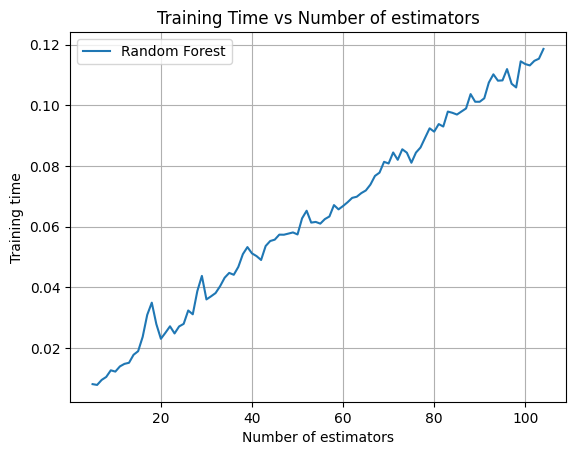

In [35]:
plt.plot(num_est, inf_time, label='Random Forest')
plt.xlabel('Number of estimators')
plt.ylabel('Training time')
plt.legend()
plt.grid()
plt.title('Training Time vs Number of estimators')
plt.show()

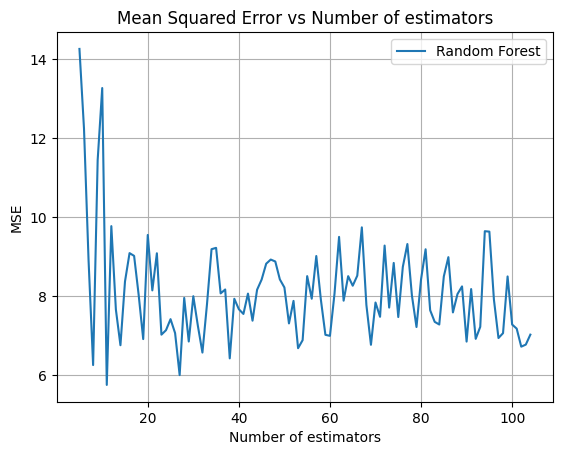

In [39]:
plt.plot(num_est, mse_list, label='Random Forest')
plt.xlabel('Number of estimators')
plt.ylabel('MSE')
plt.legend()
plt.grid()
plt.title('Mean Squared Error vs Number of estimators')
plt.show()

### Plotting Training time and accuracies vs number of estimators (Classification)

In [42]:
# loading the data
file_path = './WineQT.csv'

data = pd.read_csv(file_path)
df = pd.DataFrame(data)
df = df.drop(df.columns[-1], axis=1)
labels = df.columns.tolist()

num_features = df.shape[1]-1
num_classes = df.iloc[:, -1].nunique()

X = df.iloc[:, :-1].values
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std


f=0.8

y = df.iloc[:, -1].values
y = y - 3

y = y/5
y = np.where(y<0.5,0,1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-f, random_state=42)
# then splitting the remaining data into val and test (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [26]:
acc_list = []
inf_time = []
num_est = []

for n in range(100):
    rf_classifier = RandomForest(num_trees=n+5,max_depth=10,min_samples_split=2,num_features=5,task='classification')
    t1 = time.time()
    rf_classifier.fit(f=0.6,m=10,X_train=X_train, y_train=y_train)
    t2 = time.time()
    predictions = rf_classifier.predict(X_test)
    acc = accuracy_score(y_true=y_test,y_pred=predictions)
    num_est.append(n+5)
    acc_list.append(acc)
    inf_time.append(t2-t1)
    


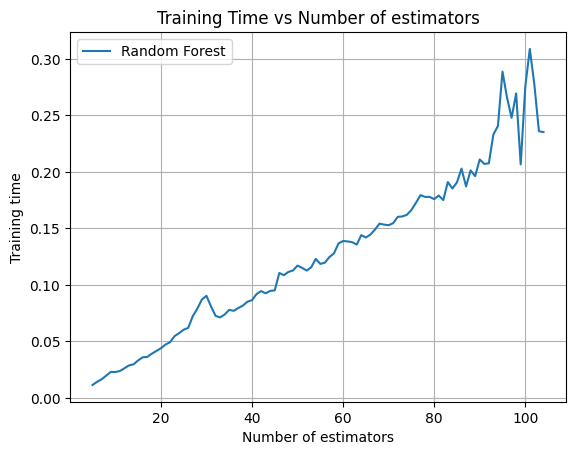

In [27]:
plt.plot(num_est, inf_time, label='Random Forest')
plt.xlabel('Number of estimators')
plt.ylabel('Training time')
plt.legend()
plt.grid()
plt.title('Training Time vs Number of estimators')
plt.show()

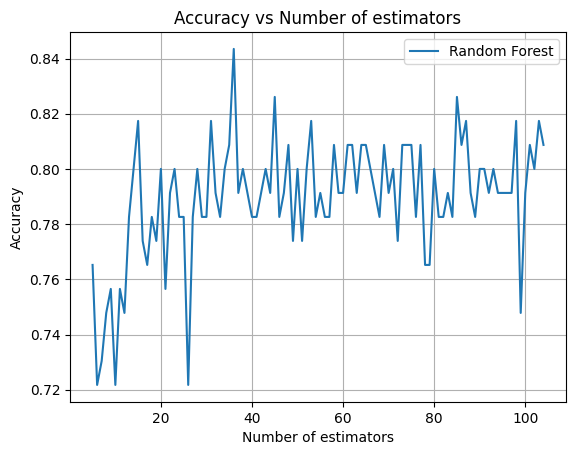

In [38]:
plt.plot(num_est, acc_list, label='Random Forest')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title('Accuracy vs Number of estimators')
plt.show()

## Comparison of best Random Forest with Adaboost and GradientBoosted Decision Trees

The following table mentions the respective accuracy (for classification) and MSE(for regression) of the 3 ensemble techniques


| Task           |Ensemble Model                          |Accuracy/MSE                         |
|----------------|-------------------------------|-----------------------------|
|Classification|Random Forest            |0.81 accuracy           |
|          |Adaboost+DT            |0.73 accuracy           |
|          |Gradient Boosted DT|0.78 accuracy|
|Regression    |Random Forest      |6.85 MSE            |
|          |Adaboost+DT       |18.59 MSE            |
|          |Gradient Boosted       |11.58 MSE            |
